In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = pd.DataFrame({
    "PatientAge": data.PatientAge,
    "PatientGender": data.PatientGender,
    
})
y

0       524 days
1      2046 days
2     15455 days
3      4354 days
4      2207 days
         ...    
795     579 days
796    5109 days
797    2125 days
798     518 days
799     483 days
Length: 800, dtype: timedelta64[ns]

In [2]:

# X = data.drop(['PostalCode','DateSurveyed','obreak_date','datebone','obone_text','rxother_text'
# ,'rx2_other_text','norxo_text','obone_text','obreak_obone_text'],axis=1)

dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})


In [3]:
y.time

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.time < 100).value_counts()

False    751
True      49
Name: time, dtype: int64

In [4]:
swapped.event = swapped.event.astype(bool)
swapped.event
structured_array = np.rec.array(swapped.to_records(index=False))

In [5]:
swapped

,event,time
0,True,524
1,True,2046
2,True,15455
3,True,4354
4,True,2207
...,...,...
795,True,579
796,True,5109
797,True,2125
798,True,518


In [6]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# X: input features, y: survival outcomes

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO feature selection
lasso = LassoCV(cv=5)
lasso.fit(X_scaled, swapped.time)
selected_features = lasso.coef_ != 0

# Filter the selected feature names
feature_names = X.columns[selected_features].tolist()

# Create a new DataFrame with selected features and survival outcomes
selected_data = pd.concat([swapped[['time', 'event']], X.loc[:, feature_names]], axis=1)

# Fit CoxPH model on the selected features
cph = CoxPHFitter()
cph.fit(selected_data, duration_col='time', event_col='event')

# Assess model performance using cross-validation
c_index_values = k_fold_cross_validation(cph, selected_data, duration_col='time', event_col='event', k=5, scoring_method='concordance_index')
c_index_mean = np.mean(c_index_values)
print("Cross-validated C-index: {:.3f}".format(c_index_mean))




Cross-validated C-index: 0.629


In [7]:
from pycaret.datasets import get_data
from pycaret.regression import *
mergedData = pd.concat([X,swapped.time],axis=1)
clf = setup(mergedData, target='time')


,Description,Value
0,Session id,1271
1,Target,time
2,Target type,Regression
3,Original data shape,"(800, 190)"
4,Transformed data shape,"(800, 190)"
5,Transformed train set shape,"(560, 190)"
6,Transformed test set shape,"(240, 190)"
7,Numeric features,189
8,Preprocess,True
9,Imputation type,simple


In [8]:

best_model = compare_models()



,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:51:37
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [9]:
best_model

ElasticNet(random_state=1271)

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
# X: input features, y: survival outcomes

# Calculate correlation matrix
correlation_matrix = X.corr()

# Set correlation threshold
correlation_threshold = 0.941

# Identify highly correlated feature pairs
highly_correlated_pairs = np.where(np.abs(correlation_matrix) > correlation_threshold)
highly_correlated_features = set()

for i, j in zip(*highly_correlated_pairs):
    if i != j and i not in highly_correlated_features and j not in highly_correlated_features:
        feature_i = X.columns[i]
        feature_j = X.columns[j]
        highly_correlated_features.add(feature_i)
        print(f"Highly correlated features: {feature_i}, {feature_j}")

# Remove highly correlated features from X
X_filtered = X.drop(highly_correlated_features, axis=1)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Perform feature selection with HuberRegressor
threshold = 10  # Adjust the threshold as desired
huber = best_model
huber.fit(X_scaled, swapped.time)
feature_importances = np.abs(huber.coef_)
selected_features = feature_importances > threshold

# Filter the selected feature names
feature_names = X_filtered.columns[selected_features].tolist()

# Create a new DataFrame with selected features and survival outcomes
selected_data = pd.concat([swapped[['time', 'event']], X_filtered.loc[:, feature_names]], axis=1)

# Fit CoxPH model on the selected features
cph = CoxPHFitter()
cph.fit(selected_data, duration_col='time', event_col='event')

# Assess model performance using cross-validation
c_index_values = k_fold_cross_validation(cph, selected_data, duration_col='time', event_col='event', k=5, scoring_method='concordance_index')
c_index_mean = np.mean(c_index_values)
print("Cross-validated C-index: {:.3f}".format(c_index_mean))
selected_data.drop(['time','event'],axis=1,inplace=True)

Highly correlated features: whopt, whoans
Highly correlated features: whoans, whopt
Highly correlated features: hasgp, choosehcp_0
Highly correlated features: choosehcp_0, hasgp
Highly correlated features: bmd, bmdresult
Highly correlated features: bmdresult, bmd
Highly correlated features: predxop, dxdescribe
Highly correlated features: dxdescribe, predxop
Highly correlated features: Chld_task_bmdr, BMDDataCollectionFormId
Highly correlated features: Chld_task_bmdr, bmdf_dis_refused_hcp_dis
Highly correlated features: Chld_task_bmdr, bmdf_dis_refused_too_far
Highly correlated features: BMDDataCollectionFormId, Chld_task_bmdr
Highly correlated features: BMDDataCollectionFormId, bmdf_dis_refused_hcp_dis
Highly correlated features: BMDDataCollectionFormId, bmdf_dis_refused_too_far
Highly correlated features: bmdf_dis_refused_hcp_dis, Chld_task_bmdr
Highly correlated features: bmdf_dis_refused_hcp_dis, BMDDataCollectionFormId
Highly correlated features: bmdf_dis_refused_hcp_dis, bmdf_dis_

In [11]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

X_train, X_test, y_train, y_test = train_test_split(selected_data, structured_array, test_size=0.2, random_state=42)

# Create an instance of the RandomSurvivalForest model
model = RandomSurvivalForest()

# Fit the model on the training data
model.fit(X_train, y_train)

# Calculate the baseline performance
baseline_score = concordance_index(y_test['time'], -model.predict(X_test), y_test['event'])

# Initialize an array to store the feature importances
feature_importances = np.zeros(X_train.shape[1])

# Perform feature importance calculation
for i in range(X_train.shape[1]):
    # Make a copy of the test set
    X_permuted = X_test.copy()

    # Permute the values of the feature at index i
    X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])

    # Calculate the permuted score
    permuted_score = concordance_index(y_test['time'], -model.predict(X_permuted), y_test['event'])

    # Calculate the feature importance as the difference between the baseline score and permuted score
    feature_importances[i] = baseline_score - permuted_score

# Normalize the feature importances
feature_importances /= np.sum(feature_importances)

# Print the feature importances
feature_names = X_train.columns

#for feature_name, importance in zip(feature_names, feature_importances):
    #print(f"Feature: {feature_name}, Importance: {importance}")

df = pd.DataFrame()
for name, importance in zip(feature_names, feature_importances):
    df = pd.concat([df, pd.DataFrame({'Feature Name': [name], 'Feature Importance': [importance]})], ignore_index=True)

df = df.sort_values('Feature Importance', ascending=False)



In [12]:
df

,Feature Name,Feature Importance
20,ptfall,1.591176
43,obreak_hip,0.232353
54,whereliv,0.202941
55,education,0.111765
49,oralster,0.085294
...,...,...
57,diabetes,-0.108824
75,rsrch_data_use,-0.111765
73,specialistReferral,-0.122059
44,obreak_frac_count,-0.150000


In [13]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis()
estimator.fit(selected_data, structured_array)

CoxPHSurvivalAnalysis()

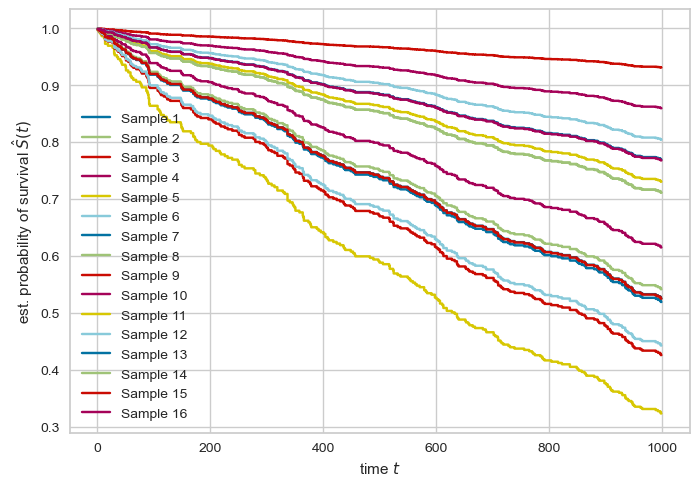

In [14]:
import matplotlib.pyplot as plt

pred_surv = estimator.predict_survival_function(selected_data.loc[:15])
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")